MILESTONE-1

In [ ]:
import pandas as pd
from pathlib import Path


csv_path = r"C:\Users\dandu\Downloads\Flight_delay.csv (1)\Flight_delay.csv"

#A small peek 
peek = pd.read_csv(csv_path, nrows=10)
print(peek.shape)
peek.head()


In [2]:

sample = pd.read_csv(csv_path, nrows=50_000, low_memory=False)

# Normalizing column names to inspect 
sample.columns = sample.columns.str.strip().str.lower()
print("Columns:", list(sample.columns))
print("Rows x Cols:", sample.shape)

Columns: ['dayofweek', 'date', 'deptime', 'arrtime', 'crsarrtime', 'uniquecarrier', 'airline', 'flightnum', 'tailnum', 'actualelapsedtime', 'crselapsedtime', 'airtime', 'arrdelay', 'depdelay', 'origin', 'org_airport', 'dest', 'dest_airport', 'distance', 'taxiin', 'taxiout', 'cancelled', 'cancellationcode', 'diverted', 'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']
Rows x Cols: (50000, 29)


In [3]:
# dtypes
dtypes = sample.dtypes.sort_values()
display(dtypes)

# missing values (top 25)
na = sample.isna().sum().sort_values(ascending=False)
display(na.head(25))

# memory estimate for sample
print("Sample memory MB:", sample.memory_usage(deep=True).sum()/1e6)

# quick date range
for cand in ["fl_date","flightdate","date","flight_date"]:
    if cand in sample.columns:
        s = pd.to_datetime(sample[cand], errors="coerce")
        print(f"Date column detected: {cand}  |  range: {s.min()} → {s.max()}")
        break


dayofweek             int64
nasdelay              int64
weatherdelay          int64
carrierdelay          int64
diverted              int64
cancelled             int64
taxiout               int64
taxiin                int64
distance              int64
securitydelay         int64
depdelay              int64
arrdelay              int64
lateaircraftdelay     int64
crselapsedtime        int64
actualelapsedtime     int64
flightnum             int64
crsarrtime            int64
arrtime               int64
deptime               int64
airtime               int64
org_airport          object
dest                 object
dest_airport         object
tailnum              object
airline              object
uniquecarrier        object
cancellationcode     object
date                 object
origin               object
dtype: object

dest_airport         215
org_airport          175
dayofweek              0
securitydelay          0
nasdelay               0
weatherdelay           0
carrierdelay           0
diverted               0
cancellationcode       0
cancelled              0
taxiout                0
taxiin                 0
distance               0
dest                   0
origin                 0
date                   0
depdelay               0
arrdelay               0
airtime                0
crselapsedtime         0
actualelapsedtime      0
tailnum                0
flightnum              0
airline                0
uniquecarrier          0
dtype: int64

Sample memory MB: 39.673222
Date column detected: date  |  range: 2019-01-01 00:00:00 → 2019-12-01 00:00:00


In [4]:
# candidate aliases for common fields
aliases = {
    "carrier": ["op_carrier","mkt_carrier","airline","carrier","carrier_name","unique_carrier"],
    "origin": ["origin","origin_airport","originairport","from","airport from"],
    "dest":   ["dest","destination","destination_airport","to","airport to"],
    "fl_date":["fl_date","flightdate","date","flight_date"],
    "crs_dep_time":["crs_dep_time","sched_dep_time","scheduled_departure","crsdeptime","crs_dep"],
    "dep_time":["dep_time","actual_departure","deptime","departure_time"],
    "arr_time":["arr_time","actual_arrival","arrtime","arrival_time"],
    "dep_delay":["dep_delay","departure_delay","depdelay"],
    "arr_delay":["arr_delay","arrival_delay","arrdelay"],
    "cancellation_code":["cancellation_code","cancel_code","canc_code"],
    "cancelled":["cancelled","is_cancelled","canceled"],
    "carrier_delay":["carrier_delay","delaycarrier","carrier_delay_minutes"],
    "weather_delay":["weather_delay","delayweather"],
    "nas_delay":["nas_delay","delaynas","air_system_delay","air_traffic_delay"],
    "security_delay":["security_delay","delaysecurity"],
    "late_aircraft_delay":["late_aircraft_delay","delaylateaircraft","lateaircraft_delay"],
    "distance":["distance","dist"]
}

cols = {}
for k, alts in aliases.items():
    for a in alts:
        if a in sample.columns:
            cols[k] = a
            break

cols 

{'carrier': 'airline',
 'origin': 'origin',
 'dest': 'dest',
 'fl_date': 'date',
 'dep_time': 'deptime',
 'arr_time': 'arrtime',
 'dep_delay': 'depdelay',
 'arr_delay': 'arrdelay',
 'cancelled': 'cancelled',
 'distance': 'distance'}

In [5]:
# core columns?
required_any = ["carrier","origin","dest","fl_date","arr_delay","dep_delay"]
print("Found (core):", {k: cols.get(k) for k in required_any})

# cause columns?
cause_keys = ["carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay"]
print("Found (causes):", {k: cols.get(k) for k in cause_keys})

# cancellations?
print("Found cancellations:", {k: cols.get(k) for k in ["cancelled","cancellation_code"]})

# quick cardinalities
for k in ["carrier","origin","dest"]:
    if k in cols:
        vc = sample[cols[k]].astype("category")
        print(k, "unique:", vc.nunique(), "| top:", vc.value_counts().head(5).to_dict())

Found (core): {'carrier': 'airline', 'origin': 'origin', 'dest': 'dest', 'fl_date': 'date', 'arr_delay': 'arrdelay', 'dep_delay': 'depdelay'}
Found (causes): {'carrier_delay': None, 'weather_delay': None, 'nas_delay': None, 'security_delay': None, 'late_aircraft_delay': None}
Found cancellations: {'cancelled': 'cancelled', 'cancellation_code': None}
carrier unique: 5 | top: {'Southwest Airlines Co.': 19951, 'Skywest Airlines Inc.': 11814, 'United Air Lines Inc.': 10861, 'US Airways Inc.': 5376, 'Delta Air Lines Inc.': 1998}
origin unique: 194 | top: {'ORD': 4099, 'DEN': 3099, 'SFO': 2946, 'LAS': 2760, 'LAX': 2607}
dest unique: 194 | top: {'ORD': 3400, 'SFO': 3098, 'LAX': 2631, 'DEN': 2574, 'LAS': 2453}


In [6]:
# propose categorical & numeric columns from the sample
# for encoding
cat_like = [cols.get("carrier"), cols.get("origin"), cols.get("dest")]
cat_like = [c for c in cat_like if c]

num_like = []
for k in ["dep_delay","arr_delay","carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay","distance"]:
    if cols.get(k):
        num_like.append(cols[k])

dtype_plan = {
    "categorical": cat_like,
    "numeric_downcast": num_like,
    "datetime": cols.get("fl_date"),
    "hhmm_time": cols.get("crs_dep_time")
}
dtype_plan


{'categorical': ['airline', 'origin', 'dest'],
 'numeric_downcast': ['depdelay', 'arrdelay', 'distance'],
 'datetime': 'date',
 'hhmm_time': None}

In [7]:
out_dir = Path("data_interim"); out_dir.mkdir(parents=True, exist_ok=True)

# 5% or max 100k rows 
rows = int( min(100_000, (len(sample) * 0.05) or 50_000) )

work = pd.read_csv(csv_path, nrows=rows, low_memory=False)
work.columns = work.columns.str.strip().str.lower()

work.to_parquet(out_dir / "flights_sample.parquet", index=False)
(out_dir / "flights_sample.parquet").as_posix()


'data_interim/flights_sample.parquet'

In [9]:
from datetime import datetime
notes = f"""# Step 2 — Schema probe (auto log)
Date: {datetime.now():%Y-%m-%d %H:%M}
File: {csv_path}

Rows examined: {len(sample)}
Columns: {len(sample.columns)}
Detected columns: {cols}

Missing (top 10):
{na.head(10).to_string()}
"""
Path("reports").mkdir(exist_ok=True, parents=True)
(Path("reports") / "preprocessing_summary.md").write_text(notes, encoding="utf-8")
print("DONE")

DONE


In [10]:
import pandas as pd
from pathlib import Path

csv_path = r"C:\Users\dandu\Downloads\Flight_delay.csv (1)\Flight_delay.csv"

df = pd.read_csv(csv_path, low_memory=False)

# normalizing column names
df.columns = df.columns.str.strip().str.lower()
print("Rows:", len(df), "Cols:", len(df.columns))


Rows: 484551 Cols: 29


In [11]:
print(df.columns.tolist())


['dayofweek', 'date', 'deptime', 'arrtime', 'crsarrtime', 'uniquecarrier', 'airline', 'flightnum', 'tailnum', 'actualelapsedtime', 'crselapsedtime', 'airtime', 'arrdelay', 'depdelay', 'origin', 'org_airport', 'dest', 'dest_airport', 'distance', 'taxiin', 'taxiout', 'cancelled', 'cancellationcode', 'diverted', 'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']


In [12]:
import pandas as pd

# Ensuring date column is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# for Year, Month 
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Departure hour 
df["deptime"] = df["deptime"].astype(str).str.zfill(4)   
df["dep_hour"] = df["deptime"].str[:2].astype(int)

# Route 
df["route"] = df["origin"].astype(str) + "-" + df["dest"].astype(str)

# Delay flags
df["arrdel15"] = (df["arrdelay"] >= 15).astype(int)
df["depdel15"] = (df["depdelay"] >= 15).astype(int)

# Total delay causes
cause_cols = ["carrierdelay","weatherdelay","nasdelay","securitydelay","lateaircraftdelay"]
df[cause_cols] = df[cause_cols].fillna(0)
df["total_delay_causes"] = df[cause_cols].sum(axis=1)




In [13]:
from pathlib import Path

Path("data_clean").mkdir(parents=True, exist_ok=True)

df.to_parquet("data_clean/flights_clean.parquet", index=False)

df.sample(frac=0.05, random_state=42).to_parquet("data_clean/flights_sample.parquet", index=False)


In [14]:
df.to_parquet("data_clean/flights_clean.parquet", index=False)
df.sample(frac=0.05, random_state=42).to_parquet("data_clean/flights_sample.parquet", index=False)


In [15]:
import csv
from pathlib import Path

# Picking key columns and descriptions 
feature_dict = [
    ("date", "datetime64", "Flight date"),
    ("year", "int", "Year extracted from date"),
    ("month", "int", "Month extracted from date"),
    ("dayofweek", "int", "Day of week (0=Mon, 6=Sun)"),
    ("dep_hour", "int", "Scheduled departure hour"),
    ("route", "str", "Origin-Destination pair"),
    ("arrdelay", "float", "Arrival delay (minutes, negative = early)"),
    ("depdelay", "float", "Departure delay (minutes, negative = early)"),
    ("arrdel15", "int (0/1)", "Arrival delay ≥15 min flag"),
    ("depdel15", "int (0/1)", "Departure delay ≥15 min flag"),
    ("carrierdelay", "float", "Delay due to carrier (minutes)"),
    ("weatherdelay", "float", "Delay due to weather (minutes)"),
    ("nasdelay", "float", "Delay due to National Airspace System (minutes)"),
    ("securitydelay", "float", "Delay due to security issues (minutes)"),
    ("lateaircraftdelay", "float", "Delay due to late aircraft (minutes)"),
    ("total_delay_causes", "float", "Sum of all delay causes"),
    ("cancelled", "int (0/1)", "Cancellation flag"),
    ("cancellationcode", "str", "Cancellation code (A,B,C,D)"),
    ("cancellation_type", "str", "Mapped reason for cancellation"),
    ("origin", "str", "Origin airport code"),
    ("dest", "str", "Destination airport code"),
    ("airline", "str", "Airline name/code"),
    ("flightnum", "str/int", "Flight number"),
    ("tailnum", "str", "Tail number (aircraft identifier)"),
    ("distance", "float", "Flight distance (miles)"),
]

Path("reports").mkdir(parents=True, exist_ok=True)

with open("reports/feature_dictionary.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["column_name", "type", "description"])
    writer.writerows(feature_dict)

print("Feature dictionary done")


Feature dictionary done


In [16]:
import shutil
from pathlib import Path


clean_full = Path("data_clean/flights_clean.parquet")
clean_sample = Path("data_clean/flights_sample.parquet")
summary = Path("reports/preprocessing_summary.md")
dictionary = Path("reports/feature_dictionary.csv")


downloads = Path.home() / "Downloads"

# Copying files
shutil.copy(clean_full, downloads / clean_full.name)
shutil.copy(clean_sample, downloads / clean_sample.name)
shutil.copy(summary, downloads / summary.name)
shutil.copy(dictionary, downloads / dictionary.name)

print("DONE")


DONE


MILESTONE-2

In [17]:
df = pd.read_parquet("data_clean/flights_clean.parquet")
df.to_csv("data_clean/flights_clean.csv", index=False)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

df = pd.read_parquet("data_clean/flights_sample.parquet")

Path("reports/figures").mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid")


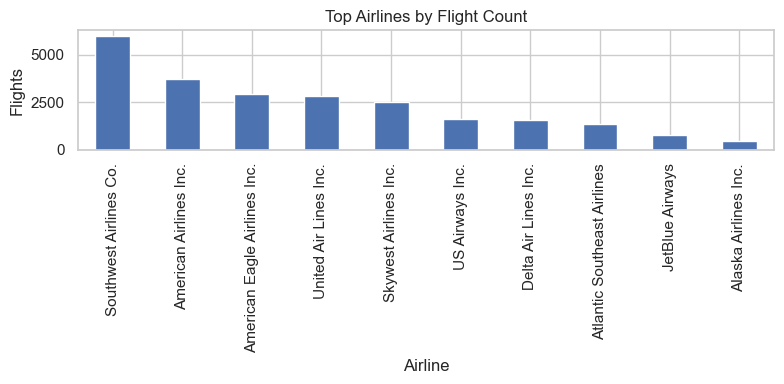

In [19]:
plt.figure(figsize=(8,4))
df["airline"].value_counts().head(10).plot(kind="bar")
plt.title("Top Airlines by Flight Count")
plt.xlabel("Airline"); plt.ylabel("Flights")
plt.tight_layout()
plt.savefig("reports/figures/top_airlines.png")
plt.show()


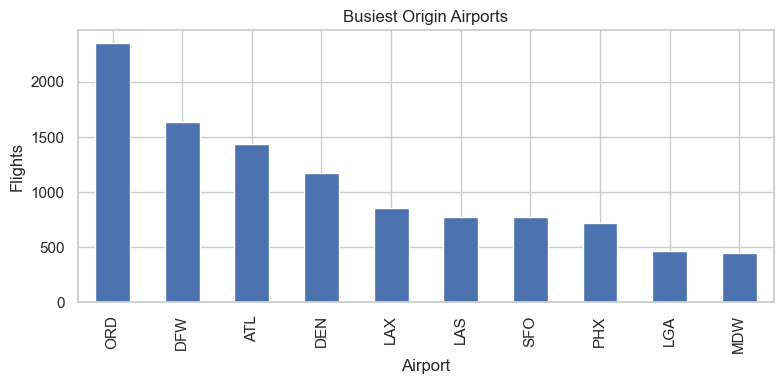

In [20]:
plt.figure(figsize=(8,4))
df["origin"].value_counts().head(10).plot(kind="bar")
plt.title("Busiest Origin Airports")
plt.xlabel("Airport"); plt.ylabel("Flights")
plt.tight_layout()
plt.savefig("reports/figures/busiest_airports.png")
plt.show()

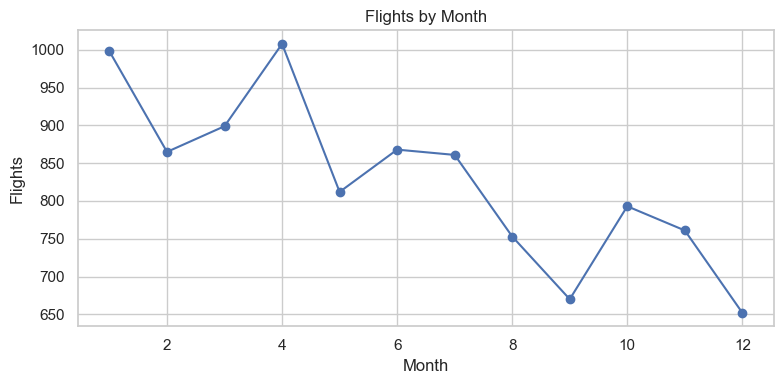

In [21]:
plt.figure(figsize=(8,4))
df.groupby("month").size().plot(kind="line", marker="o")
plt.title("Flights by Month")
plt.xlabel("Month"); plt.ylabel("Flights")
plt.tight_layout()
plt.savefig("reports/figures/flights_by_month.png")
plt.show()


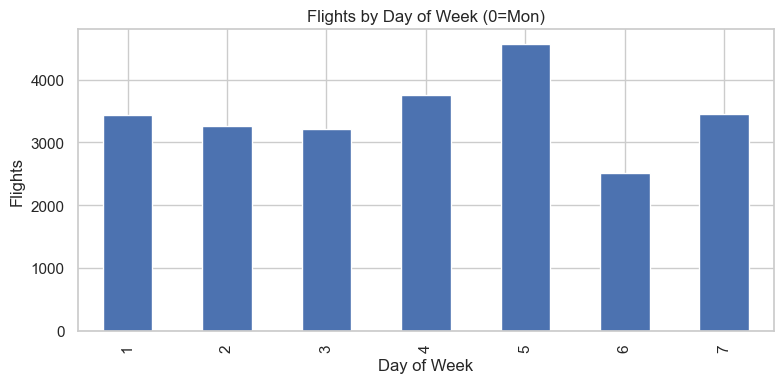

In [22]:
plt.figure(figsize=(8,4))
df.groupby("dayofweek").size().plot(kind="bar")
plt.title("Flights by Day of Week (0=Mon)")
plt.xlabel("Day of Week"); plt.ylabel("Flights")
plt.tight_layout()
plt.savefig("reports/figures/flights_by_day.png")
plt.show()

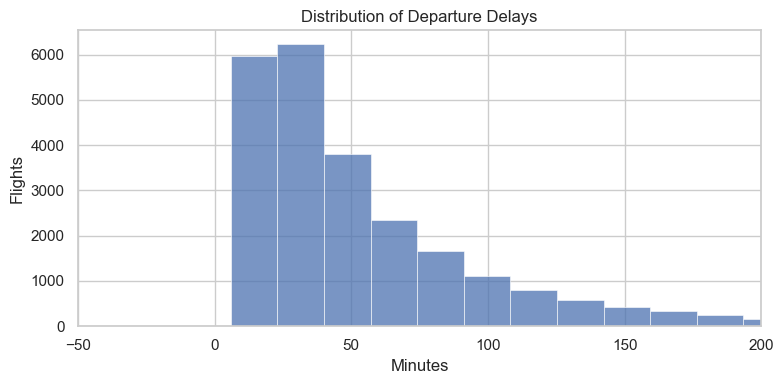

In [23]:
plt.figure(figsize=(8,4))
sns.histplot(df["depdelay"], bins=100, kde=False)
plt.xlim(-50, 200)  # focus on normal range
plt.title("Distribution of Departure Delays")
plt.xlabel("Minutes"); plt.ylabel("Flights")
plt.tight_layout()
plt.savefig("reports/figures/dep_delay_dist.png")
plt.show()


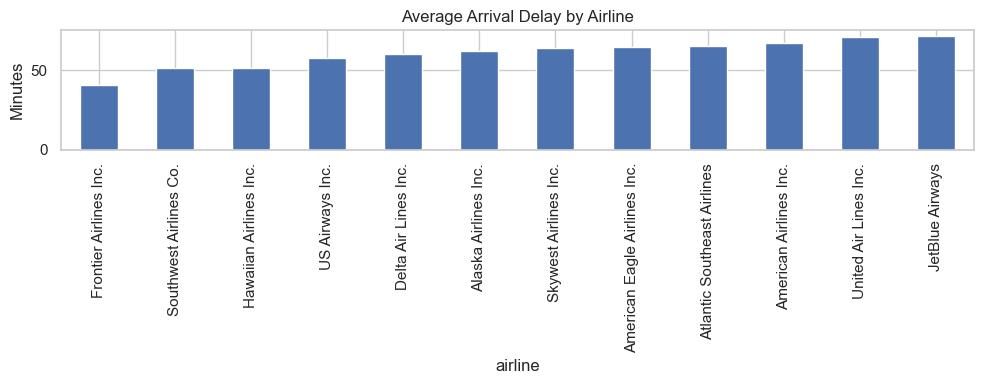

In [24]:
plt.figure(figsize=(10,4))
df.groupby("airline")["arrdelay"].mean().sort_values().plot(kind="bar")
plt.title("Average Arrival Delay by Airline")
plt.ylabel("Minutes")
plt.tight_layout()
plt.savefig("reports/figures/avg_arr_delay_airline.png")
plt.show()


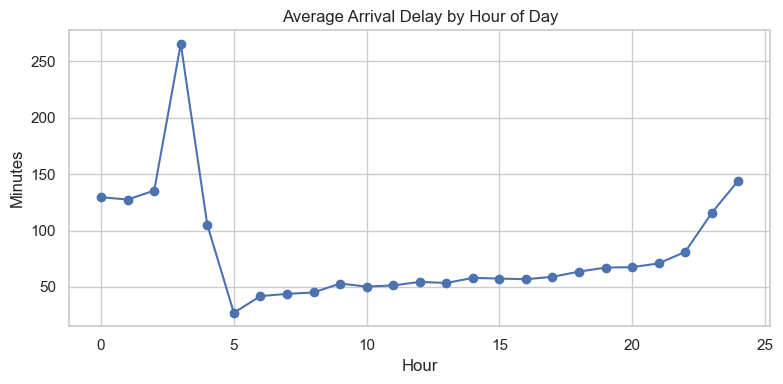

In [25]:
plt.figure(figsize=(8,4))
df.groupby("dep_hour")["arrdelay"].mean().plot(kind="line", marker="o")
plt.title("Average Arrival Delay by Hour of Day")
plt.xlabel("Hour"); plt.ylabel("Minutes")
plt.tight_layout()
plt.savefig("reports/figures/arr_delay_by_hour.png")
plt.show()

<Figure size 1200x600 with 0 Axes>

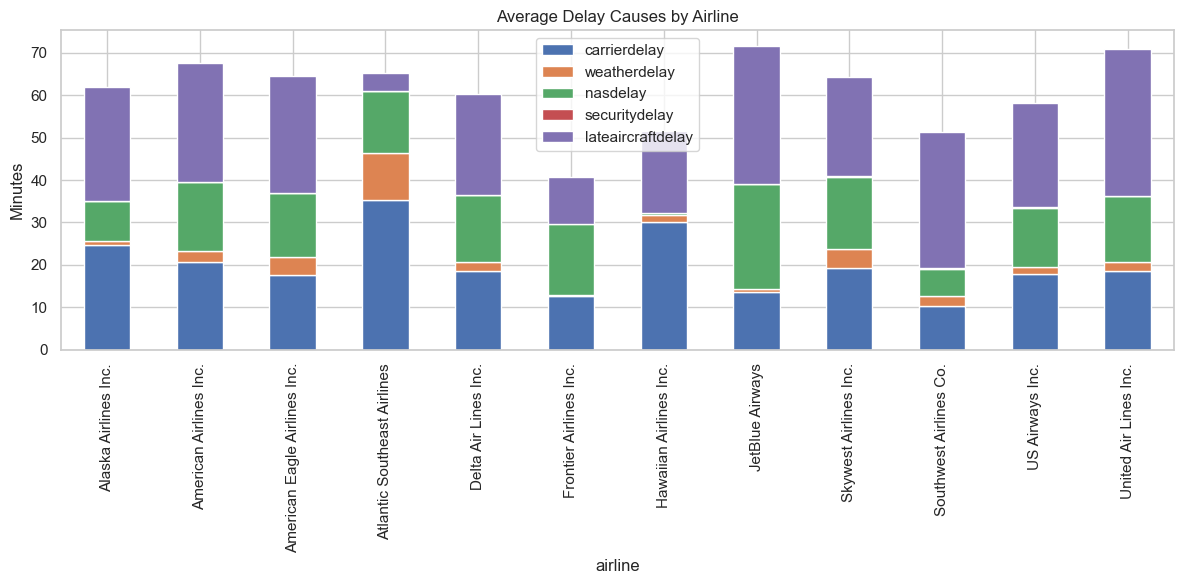

In [26]:
plt.figure(figsize=(12,6))
cause_cols = ["carrierdelay","weatherdelay","nasdelay","securitydelay","lateaircraftdelay"]
df[cause_cols] = df[cause_cols].fillna(0)
df.groupby("airline")[cause_cols].mean().plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Average Delay Causes by Airline")
plt.ylabel("Minutes")
plt.tight_layout()
plt.savefig("reports/figures/delay_causes_airline.png")
plt.show()


In [27]:
obs = """# Observations (Milestone-2)

1. Airline flight counts show that Southwest Airlines Co. and American Airlines Inc are the busiest carriers.
2. The busiest origin airports are ORD, reflecting hub traffic.
3. Flight volume peaks in Month=4 (April), indicating strong summer demand.
4. More flights operate on (Day 4-5), while weekends are lighter.
5. Most departure delays are under 50 mins, but a long tail exists up to 200+ mins.
6. Airline Jet Blue Airways shows the highest average arrival delay (~90 mins), while Frontier Airlines Co is the most punctual.
7. Delays spike during morning hours (03:00–04:00), mornings are more punctual.
8. Across airlines, Late Aircraft contributes the most to delays, followed by carrier and NAS delays.
"""
Path("reports").mkdir(exist_ok=True, parents=True)
(Path("reports") / "observations_m2.md").write_text(obs, encoding="utf-8")


741

In [28]:
import os
print(os.path.abspath("reports/preprocessing_summary.md"))


C:\Users\dandu\reports\preprocessing_summary.md


In [29]:
from datetime import datetime
from pathlib import Path

Path("reports").mkdir(parents=True, exist_ok=True)

with open("reports/preprocessing_summary.md", "a", encoding="utf-8") as f:
    f.write("\n\n# Step 3 — Cleaning & Feature Engineering\n")
    f.write(f"Date: {datetime.now():%Y-%m-%d %H:%M}\n")
    f.write("- Converted `date` to datetime\n")
    f.write("- Added `year`, `month` (dayofweek already existed)\n")
    f.write("- Derived `dep_hour` from deptime\n")
    f.write("- Created `route` (origin-dest)\n")
    f.write("- Added delay flags: `arrdel15`, `depdel15`\n")
    f.write("- Filled NAs in cause columns (`carrierdelay`, `weatherdelay`, `nasdelay`, `securitydelay`, `lateaircraftdelay`) with 0\n")
    f.write("- Added `total_delay_causes`\n")
    f.write("- Mapped `cancellationcode` → `cancellation_type`\n")
    f.write("- Saved cleaned dataset and 5% sample parquet\n")

print("Step-3 notes done")


Step-3 notes done


In [30]:
with open("reports/preprocessing_summary.md", "r", encoding="utf-8") as f:
    print(f.read())


# Step 2 — Schema probe (auto log)
Date: 2025-08-25 17:32
File: C:\Users\dandu\Downloads\Flight_delay.csv (1)\Flight_delay.csv

Rows examined: 50000
Columns: 29
Detected columns: {'carrier': 'airline', 'origin': 'origin', 'dest': 'dest', 'fl_date': 'date', 'dep_time': 'deptime', 'arr_time': 'arrtime', 'dep_delay': 'depdelay', 'arr_delay': 'arrdelay', 'cancelled': 'cancelled', 'distance': 'distance'}

Missing (top 10):
dest_airport        215
org_airport         175
dayofweek             0
securitydelay         0
nasdelay              0
weatherdelay          0
carrierdelay          0
diverted              0
cancellationcode      0
cancelled             0


# Step 3 — Cleaning & Feature Engineering
Date: 2025-08-25 17:43
- Converted `date` to datetime
- Added `year`, `month` (dayofweek already existed)
- Derived `dep_hour` from deptime
- Created `route` (origin-dest)
- Added delay flags: `arrdel15`, `depdel15`
- Filled NAs in cause columns (`carrierdelay`, `weatherdelay`, `nasdelay`, `se

In [31]:
import pandas as pd

df = pd.read_parquet("data_clean/flights_clean.parquet")

df.to_csv("data_clean/flights_clean.csv", index=False)

df.sample(frac=0.05, random_state=42).to_csv("data_clean/flights_sample.csv", index=False)

print("Done")


Done


In [32]:
import shutil
from pathlib import Path

downloads = Path.home() / "Downloads"

shutil.copy("data_clean/flights_clean.csv", downloads / "flights_clean.csv")
shutil.copy("data_clean/flights_sample.csv", downloads / "flights_sample.csv")

print("Done")


Done
